### 영상 특징 검출
이전 Post에서는 **LPF를 통한 Noise제거, HPF를 통한 Feature추출**을 하였다.  
Feature는 Edge, Blur, 직선, 원, 코너점, 사각형 등 구조적인 특징이 있다.  
또한 영상의 밝기/컬러의 평균, 분산, 히스토그램, 분포, 그래디언트의 크기 및 방향 등의 화소값 관련된 특징도 있다.  

**특징 검출기(feature detector)는 영상으로부터 관심 영역의 위치(location)을 검출하는 알고리즘이다. 특징 디스크립터(feature descripter)는 영상 매칭(matching)을 위한 정보를 표현한 특징 벡터이다.**  

이번 Post에서는 코너점 검출에 의한 Feature 추출, Moment, 윤곽선, 적분영상 등 간단한 Feature Detection 및 Feature Descripter에 대해 알아본다.  
<br>

**참고사항(Edge, Corner)**  
Corner와 Edge가 주요한 Feature를 표현하는 좋은 예시가 있다.  
<img src="https://mblogthumb-phinf.pstatic.net/20160128_93/samsjang_1453971579456yB9lL_PNG/%C4%B8%C3%B3.PNG?type=w2" largesrc="javascript:location.href='https://mblogthumb-phinf.pstatic.net/20160128_93/samsjang_1453971579456yB9lL_PNG/%C4%B8%C3%B3.PNG?type=w2'" id="img_3" data-top="2269.1875"><br>
사진 출처: <a href="https://m.blog.naver.com/samsjang/220611556387">samsjang</a><br>
- 파란 상자: 움직여도 내부의 특성이 변화가 없다.
- 빨간 상자: 조금만 움직이면 내부의 특성이 변화한다.
- 검은 상자: 위아래로 움직여야지만 내부의 특성이 변화한다.

**따라서 이미지의 Feature 중에서 Edge와 Corner는 중요한 정보이다.**  

#### 필요한 라이브러리 임포트

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets 
import IPython.display as display
from ipywidgets import Layout, Button, Box, Layout, Image, IntSlider, AppLayout

#### 필요한 데이터 생성1

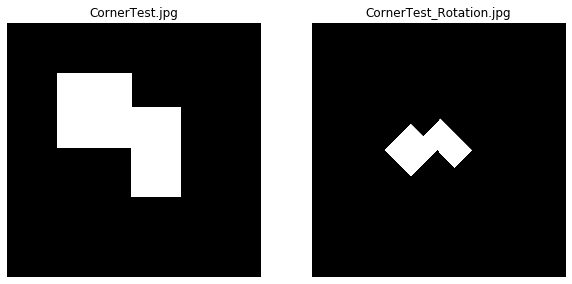

True

In [32]:
def plot(img):
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
img = np.zeros((512,512,3),dtype=np.uint8)

pt1 = 100,100
pt2 = 250,250
cv2.rectangle(img,pt1,pt2,(255,255,255),-1)

pt3 = 250,170
pt4 = 350,350
cv2.rectangle(img,pt3,pt4,(255,255,255),-1)

rows,cols,channels = img.shape
M1 = cv2.getRotationMatrix2D((rows/2,cols/2),45,0.5)
dst = cv2.warpAffine(img,M1,(rows,cols),borderValue=(0,0,0))

plt.figure(figsize=(10,10))
imgae1=plt.subplot(1,2,1)
imgae1.set_title('CornerTest.jpg')
plt.axis('off')
plt.imshow(img, cmap="gray")

imgae2=plt.subplot(1,2,2)
imgae2.set_title('CornerTest_Rotation.jpg')
plt.axis('off')
plt.imshow(dst, cmap="gray")

plt.show()
cv2.imwrite('./data/CornerTest.jpg',img)
cv2.imwrite('./data/CornerTest_Rotation.jpg',dst)

#### 필요한 데이터 생성2

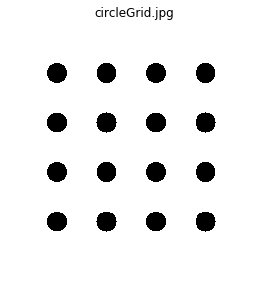

True

In [3]:
def plot(img):
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
img = np.zeros((512,512,3),dtype=np.int32)+255


for i in range(1,5):
    for j in range(1,5):
        pt1 = i*100
        pt2 = j*100
        cv2.circle(img,(pt1,pt2),20,(0,0,0),-1)


plt.figure(figsize=(10,10))
imgae1=plt.subplot(1,2,1)
imgae1.set_title('circleGrid.jpg')
plt.axis('off')
plt.imshow(img, cmap="gray")

plt.show()
cv2.imwrite('./data/circleGrid.jpg',img)

#### 필요한 데이터 생성3

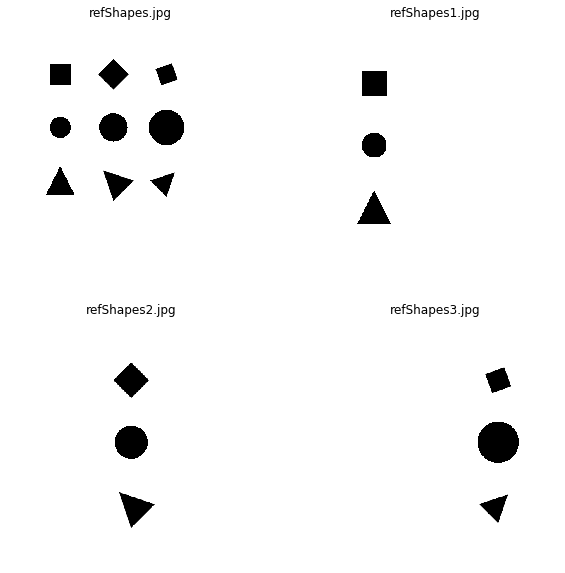

True

In [4]:
def plot(img):
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
img = np.zeros((700,700,3),dtype=np.uint8)+255
img2 = np.zeros((600,600,3),dtype=np.uint8)+255
img3 = np.zeros((600,600,3),dtype=np.uint8)+255
img4 = np.zeros((600,600,3),dtype=np.uint8)+255

pt_array = []

for i in range(1,4):
    for j in range(1,4):
        pt1 = i*150
        pt2 = j*150
        pt_array.append((pt1,pt2))

for i in range(0,9):
    if i <3:
        if i % 3 ==0:
            cv2.rectangle(img,(pt_array[i][0]-30,pt_array[i][1]-30),(pt_array[i][0]+30,pt_array[i][1]+30),(0,0,0),-1)
            cv2.rectangle(img2,(pt_array[i][0]-30,pt_array[i][1]-30),(pt_array[i][0]+30,pt_array[i][1]+30),(0,0,0),-1)
            
        elif i%3 ==1:
            cv2.circle(img,(pt_array[i][0],pt_array[i][1]),30,(0,0,0),-1)
            cv2.circle(img2,(pt_array[i][0],pt_array[i][1]),30,(0,0,0),-1)
            
        else:
            pts = np.array([[pt_array[i][0],pt_array[i][1]-40],[pt_array[i][0]-40,pt_array[i][1]+40],[pt_array[i][0]+40,pt_array[i][1]+40]])
            cv2.fillPoly(img,[pts],(0,0,0))
            cv2.fillPoly(img2,[pts],(0,0,0))
            
    elif i<6:
        if i % 3 ==0:
            cv2.rectangle(img,(pt_array[i][0]-30,pt_array[i][1]-30),(pt_array[i][0]+30,pt_array[i][1]+30),(0,0,0),-1)
        
            img_imsi = img[pt_array[i][1]-70:pt_array[i][1]+70,pt_array[i][0]-70:pt_array[i][0]+70]
            rows,cols,channels = img_imsi.shape
            M1 = cv2.getRotationMatrix2D((rows/2,cols/2),45,1)
            dst = cv2.warpAffine(img_imsi,M1,(rows,cols),borderValue=(255,255,255))
            img[pt_array[i][1]-70:pt_array[i][1]+70,pt_array[i][0]-70:pt_array[i][0]+70] = dst
            
            img3[pt_array[i][1]-70:pt_array[i][1]+70,pt_array[i][0]-70:pt_array[i][0]+70] = dst
        elif i%3 ==1:
            cv2.circle(img,(pt_array[i][0],pt_array[i][1]),40,(0,0,0),-1)
            cv2.circle(img3,(pt_array[i][0],pt_array[i][1]),40,(0,0,0),-1)
        else:
            pts = np.array([[pt_array[i][0],pt_array[i][1]-40],[pt_array[i][0]-40,pt_array[i][1]+40],[pt_array[i][0]+40,pt_array[i][1]+40]])
            cv2.fillPoly(img,[pts],(0,0,0))
            img_imsi = img[pt_array[i][1]-60:pt_array[i][1]+60,pt_array[i][0]-60:pt_array[i][0]+60]
            rows,cols,channels = img_imsi.shape
            M1 = cv2.getRotationMatrix2D((rows/2,cols/2),45,1)
            dst = cv2.warpAffine(img_imsi,M1,(rows,cols),borderValue=(255,255,255))
            img[pt_array[i][1]-60:pt_array[i][1]+60,pt_array[i][0]-60:pt_array[i][0]+60] = dst
            img3[pt_array[i][1]-60:pt_array[i][1]+60,pt_array[i][0]-60:pt_array[i][0]+60] = dst
            
    else:
        if i % 3 ==0:
            cv2.rectangle(img,(pt_array[i][0]-30,pt_array[i][1]-30),(pt_array[i][0]+30,pt_array[i][1]+30),(0,0,0),-1)
            img_imsi = img[pt_array[i][1]-70:pt_array[i][1]+70,pt_array[i][0]-70:pt_array[i][0]+70]
            rows,cols,channels = img_imsi.shape
            M1 = cv2.getRotationMatrix2D((rows/2,cols/2),20,0.8)
            dst = cv2.warpAffine(img_imsi,M1,(rows,cols),borderValue=(255,255,255))
            img[pt_array[i][1]-70:pt_array[i][1]+70,pt_array[i][0]-70:pt_array[i][0]+70] = dst
            img4[pt_array[i][1]-70:pt_array[i][1]+70,pt_array[i][0]-70:pt_array[i][0]+70] = dst
            
        elif i%3 ==1:
            cv2.circle(img,(pt_array[i][0],pt_array[i][1]),50,(0,0,0),-1)
            cv2.circle(img4,(pt_array[i][0],pt_array[i][1]),50,(0,0,0),-1)
        else:
            pts = np.array([[pt_array[i][0],pt_array[i][1]-40],[pt_array[i][0]-40,pt_array[i][1]+40],[pt_array[i][0]+40,pt_array[i][1]+40]])
            cv2.fillPoly(img,[pts],(0,0,0))
            
            img_imsi = img[pt_array[i][1]-60:pt_array[i][1]+60,pt_array[i][0]-60:pt_array[i][0]+60]
            rows,cols,channels = img_imsi.shape
            M1 = cv2.getRotationMatrix2D((rows/2,cols/2),-45,0.8)
            dst = cv2.warpAffine(img_imsi,M1,(rows,cols),borderValue=(255,255,255))
            img[pt_array[i][1]-60:pt_array[i][1]+60,pt_array[i][0]-60:pt_array[i][0]+60] = dst
            img4[pt_array[i][1]-60:pt_array[i][1]+60,pt_array[i][0]-60:pt_array[i][0]+60] = dst




plt.figure(figsize=(10,10))
imgae1=plt.subplot(2,2,1)
imgae1.set_title('refShapes.jpg')
plt.axis('off')
plt.imshow(img)

imgae2=plt.subplot(2,2,2)
imgae2.set_title('refShapes1.jpg')
plt.axis('off')
plt.imshow(img2)

imgae3=plt.subplot(2,2,3)
imgae3.set_title('refShapes2.jpg')
plt.axis('off')
plt.imshow(img3)

imgae4=plt.subplot(2,2,4)
imgae4.set_title('refShapes3.jpg')
plt.axis('off')
plt.imshow(img4)

plt.show()

cv2.imwrite('./data/refShapes.jpg',img)
cv2.imwrite('./data/refShapes1.jpg',img2)
cv2.imwrite('./data/refShapes2.jpg',img3)
cv2.imwrite('./data/refShapes3.jpg',img4)

### 코너점 검출
위에서 설명하였듯이 Image에서 코너점은 주요한 Feature중 하나이다. 이러한 코너점을 추축하는 방법은 매우 중요하다.  

<code>cv2.preCornerDetect(src,ksize)</code>: 코너점, local maxima/minima 출력, 하나의 Image에 x,y,xy에 관하여 각각 Sobel Filter로서의 결과(Edge)의 교차점이라고 생각하면 된다.<br>

**parameter**
- src: input
- ksize: Sobel Filter Mask

<br>

**식**
<p>$$dst(x,y) = I_x^{2}+I_{yy} + I_{y}^2I_{xx} -2I_{x}I_{y}I_{xy}$$</p>
<p>$$I_x = \frac{\partial I(x,y)}{\partial x},I_y = \frac{\partial I(x,y)}{\partial y}, I_{xx} = \frac{\partial^2 I(x,y)}{\partial^2 x}$$</p>
<p>$$I_{yy} = \frac{\partial^2 I(x,y)}{\partial^2 y}, I_{xy} = \frac{\partial^2 I(x,y)}{\partial x \partial y}$$</p>

<br>

<code>cv2.preCornerEigenValsAndVecs(src,blockSize,ksize)</code>: <span>$\lambda_1, \lambda_2 모두 큰 값$</span><br>

**parameter**
- src: input
- blockSize: 영상 화소 내 이웃까지의 Window
- ksize: Sobel Filter Mask

<br>

**과정**
1. 입력영상 src에서 각 픽셀의 고유값과 고유벡터를 6채널 dst에 계산
2. 영상의 모든 픽셀에 대하여 blockSize x blockSize의 이웃에 있는 미분값을 이용하여 2 x 2 크기의 gradient를 이용한 covariance matrix M의 eigenvalue <span>$\lambda_1, \lambda_2$</span>, eigenvector(<span>$x_1, y_1$</span>)와 (<span>$x_2, y_2$</span>)를 계산하여 dst에 저장


- eigenvalue <span>$\lambda_1, \lambda_2$</span>가 모두 작은 값: 평평한 영역에 있는 점
- eigenvalue <span>$\lambda_1, \lambda_2$</span> 둘 중 하나는 크고 하나는 작은 값: 에지
- eigenvalue <span>$\lambda_1, \lambda_2$</span> 두 값이 모두 큰 값: 코너
<br>

**Covariant Matrix M**
<p>$$\begin{bmatrix}
\sum_{Nbd(x,y)}I_x^2 & \sum_{Nbd(x,y)}I_xI_y \\
\sum_{Nbd(x,y)}I_xI_y & \sum_{Nbd(x,y)}I_y^2 \\
\end{bmatrix}
$$</p>

**증명**  
위의 cv2.preCornerDetect(src,ksize)과 같이 결국 핵심적인 내용은 **Edge의 교차점을 Corner**이다.  

위의 Covariant Matrix M의 eigenvalue를 검출하여 보자  
<p>$$M = \begin{bmatrix}
\sum_{Nbd(x,y)}I_x^2 - \lambda & \sum_{Nbd(x,y)}I_xI_y \\
\sum_{Nbd(x,y)}I_xI_y & \sum_{Nbd(x,y)}I_y^2 - \lambda \\
\end{bmatrix}
$$</p>
<p>$$det(M) = (I_x^2 - \lambda)(I_y^2 - \lambda) - (I_xI_y)^2$$</p>
위의 식에서 결국 찾고자 하는 Local Maxima/Minima는 <span>$I_xI_y = 0$</span>혹은 Local Maxima/Minima에 가까운점은 0에 가까운것이라는 것을 알 수 있다.  
그렇게 되는 경우 결국 EigenValue를 각각 구해보게 되면 다음과 같은 결론이 나오게 된다.  
<p>$$\lambda_1 = \sqrt{(I_x^2)}$$</p>
<p>$$\lambda_2 = \sqrt{(I_y^2)}$$</p>
위의 두개의 Eigenvalue <span>$\lambda_1, \lambda_2$</span>는 결국 Image를 x,y에 관하여 미분한 Edge를 추출하는 값을 가지게 된다.  
위와 같은 과정을 생각하면 결론을 다음과 같이 생각할 수 있다.  

- eigenvalue <span>$\lambda_1, \lambda_2$</span>가 모두 작은 값: 이미지의 x,y축 둘 다 Edge존재 X
- eigenvalue <span>$\lambda_1, \lambda_2$</span> 둘 중 하나는 크고 하나는 작은 값: x 나 y축 중 하나의 Edge만을 가짐
- eigenvalue <span>$\lambda_1, \lambda_2$</span> 두 값이 모두 큰 값: x,y축 두 개의 Edge를 가짐 => 코너점

<br>

<code>cv2.preCornerEigenVal(src,ksize)</code>: EigenValue중에서 작은 고유값이 주어진 임계값 보다 크다면, EigenValue 둘다 존재 => 코너점으로 판별<br>
<br>

<code>cv2.Harris(src,blockSize,ksize,k)</code>: 각 화소의 Harris 반응값(Harris detector responses)을 계산<br>

**식**
<p>$$dst(x,y) = det(M(x,y)) -k*trace(M(x,y))^2$$</p>
k는 Harris 코너 검출 상수로 0.01에서 0.06 사이의 값을 주로 사용한다. Harris 코너 검출 반응값의 행렬 dst에서 Local Maxima이 코너점이 된다.  
<br>

<code>cv2.cornerSubPix(image, corners, winSize, zeroZone, criteria)</code>: 입력 영상 image에서 검출된 코너점 corners를 입력하여 코너점의 위치를 부화소 수준으로 다시 계산하여 반환한다. <br>

**parameter**
- image: input
- corners: 코너점
- iwnSize: Search Window의 절반 사이즈
- zeroZone: Half of the size of the dead region in the middle of the search zone over which the summation in the formula below is not done.
- criteria: 종료 시점

<br>

<code>cv2.goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance[, corners[, mask[, blockSize[, useHarrisDetector[, k]]]]])</code>: <code>cv2.Harris() </code> or <code>cv2.preCornerEigenVal()</code>를 사용하여 얻어낸 Corner점 중 가장 값이 높은 K개의 코너점을 반환한다.<br>

**참고사항**  
더 자세한 Method사용방법이나 Corner점 검출에 관한 수식같은 경우 아래 두 링크를 참조하자.  
<a href="https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornersubpix">Open Cv 정식사이트</a><br>
<a href="https://en.wikipedia.org/wiki/Corner_detection">Wikipedia: Corner Detection Algorithm</a><br>

#### 코너점 검출1: cv2.preCornerDetect
**findLocalMaxima(): 지역 극대값의 좌표를 points 배열에 검출하여 반환한다.**  
결국에는 코너점 검출하는 방식을 사용하면 하나의 Point가 출력되는 것이아니라 **코너점 Point에서 주변의 Point까지 전부 출력하는 것을 알 수 있다.**  
즉, 특정 크기의 지역내의 극대점을 하나로서 표현함으로써 코너점을 하나로 만들기 위한 Method이다.  
- dilate: 그레이 스케일 영상에서는 반복적인 max 필터링
- erode: 그레이 스케일 영상에서는 반복적인 min 필터링

즉 dilate로서 LocalMax를 계산하고, erode로서 LocalMin을 계산한다.  
findLocalMaxima()의 계산은 다음과 같다.  
1. LocalMaxima를 dilate로서 계산
2. LocalMinima를 erode로서 계산
3. LocalMaxima2는 LocalMinima보다 큰 값으로 계산
4. LocalMaxima & LocalMaxima2를 통하여 최대값 계산
5. x,y위치를 바꿔서 반환


corners.shape= (8, 2)


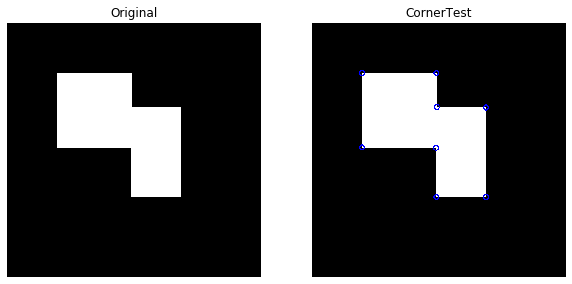

In [8]:
def findLocalMaxima(src):
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT,ksize=(11,11))
    dilate = cv2.dilate(src,kernel)
    localMax = (src==dilate)
    
    erode = cv2.erode(src,kernel)
    localMax2 = src>erode
    localMax &= localMax2
    points = np.argwhere(localMax == True)
    points[:,[0,1]] = points[:,[1,0]]
    return points

src = cv2.imread('./data/CornerTest.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
res = cv2.preCornerDetect(gray,ksize=3)
ret,res2 = cv2.threshold(np.abs(res),0.1,0,cv2.THRESH_TOZERO)

corners = findLocalMaxima(res2)
print('corners.shape=',corners.shape)

dst = src.copy()
for x,y in corners:
    cv2.circle(dst,(x,y),5,(0,0,255),2)
    
plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src, cmap="gray")

imgae2=plt.subplot(1,2,2)
imgae2.set_title('CornerTest')
plt.axis('off')
plt.imshow(dst, cmap="gray")

plt.show()

#### 코너점 검출2: conerEigenValsAndVecs
<code>cornerEigenVlasAndVecs</code>의 return은 다음과 같다.  
- res[0]: <span>$\lambda_1$</span>의 eigenvalue
- res[1]: <span>$\lambda_2$</span>의 eigenvalue
- res[3]: <span>$\lambda_1$</span>의 eigenvector[0] = <span>$x_1$</span>
- res[4]: <span>$\lambda_1$</span>의 eigenvector[1] = <span>$y_1$</span>
- res[5]: <span>$\lambda_2$</span>의 eigenvector[0] = <span>$x_2$</span>
- res[6]: <span>$\lambda_2$</span>의 eigenvector[1] = <span>$y_2$</span>

<p>$$\lambda_1 > \lambda_2$$</p>

따라서 res[1] < dst(x,y) < res[0]는 Edge, res[0] < dst(x,y)는 Corner가 된다.

res.shape= (512, 512, 6)
len(corners=) 8


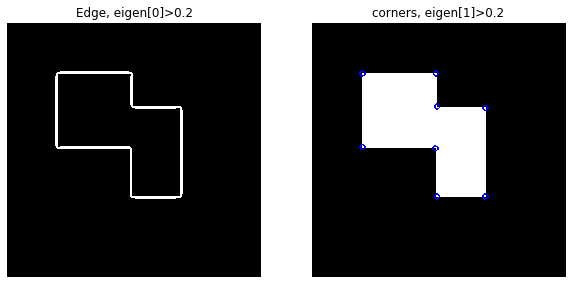

In [4]:
src = cv2.imread('./data/CornerTest.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

res = cv2.cornerEigenValsAndVecs(gray,blockSize=5,ksize=3)
print('res.shape=',res.shape)
eigen = cv2.split(res)

T = 0.2
ret,edge = cv2.threshold(eigen[0],T,255,cv2.THRESH_BINARY)
edge = edge.astype(np.uint8)

corners = np.argwhere(eigen[1]>T)
corners[:,[0,1]] = corners[:,[1,0]]
print('len(corners=)',len(corners))

dst = src.copy()
for x,y in corners:
    cv2.circle(dst,(x,y),5,(0,0,255),2)
    
plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('Edge, eigen[0]>0.2')
plt.axis('off')
plt.imshow(edge, cmap="gray")

imgae2=plt.subplot(1,2,2)
imgae2.set_title('corners, eigen[1]>0.2')
plt.axis('off')
plt.imshow(dst, cmap="gray")

plt.show()

#### 코너점 검출 3: cv2.cornerMinEigenVal()

eigen.shape= (512, 512)
len(corners)= 8


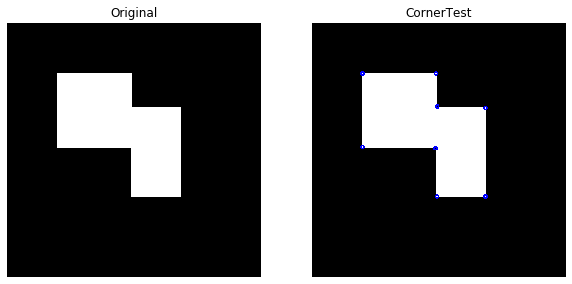

In [5]:
src = cv2.imread('./data/CornerTest.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

eigen = cv2.cornerMinEigenVal(gray,blockSize=5)
print('eigen.shape=',eigen.shape)

T = 0.2
corners = np.argwhere(eigen > T)
corners[:,[0,1]] = corners[:,[1,0]]
print('len(corners)=',len(corners))
dst = src.copy()

for x,y, in corners:
    cv2.circle(dst,(x,y),3,(0,0,255),2)
    
plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src, cmap="gray")

imgae2=plt.subplot(1,2,2)
imgae2.set_title('CornerTest')
plt.axis('off')
plt.imshow(dst, cmap="gray")

plt.show()

#### 코너점 검출 4: cv2.cornerHarris(), cv2.cornerSubPix()

corners= [[101 101]
 [249 101]
 [252 168]
 [349 171]
 [101 249]
 [248 252]
 [251 349]
 [349 349]]
corners2 [[ 99.5594   99.5577 ]
 [250.44127  99.5592 ]
 [250.5585  169.43939]
 [350.43945 169.56058]
 [ 99.55908 250.43958]
 [249.43884 250.55685]
 [249.56104 350.4409 ]
 [350.44144 350.44037]]


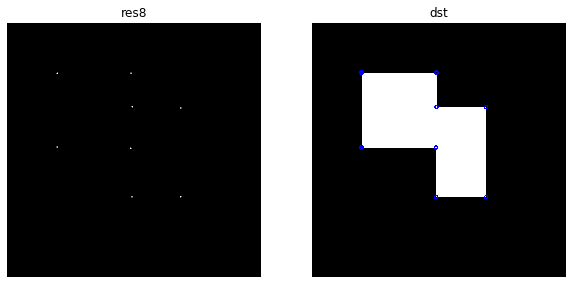

In [6]:
src = cv2.imread('./data/CornerTest.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
res = cv2.cornerHarris(gray,blockSize=5,ksize=3,k=0.01)
ret,res = cv2.threshold(np.abs(res),0.02,0,cv2.THRESH_TOZERO)

res8 = cv2.normalize(res,None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)

corners = findLocalMaxima(res)
print('corners=',corners)

corners = corners.astype(np.float32,order='C')
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,10,0.01)
corners2 = cv2.cornerSubPix(gray,corners,(5,5),(-1,-1),term_crit)
print('corners2',corners2)

dst = src.copy()
for x,y in corners2:
    cv2.circle(dst,(x,y),3,(0,0,255),2)
    
plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('res8')
plt.axis('off')
plt.imshow(res8, cmap="gray")

imgae2=plt.subplot(1,2,2)
imgae2.set_title('dst')
plt.axis('off')
plt.imshow(dst, cmap="gray")

plt.show()

#### 코너점 검출5: cv2.goodFeaturesToTrack()
각각의 코너점 출력 중 가장 값이 높은 코너점 5개 혹은 10개를 출력하였다.  
따라서 최대 코너점은 8개 이므로 10개를 출력하여도 8개만 출력되는 것을확인할 수 있다.

corners.shape= (5, 1, 2)
corners= [[[350. 350.]]

 [[250. 350.]]

 [[249. 251.]]

 [[100. 100.]]

 [[100. 250.]]]
corners2.shape= (8, 1, 2)
corners2= [[[350. 350.]]

 [[250. 350.]]

 [[249. 251.]]

 [[100. 100.]]

 [[100. 250.]]

 [[350. 170.]]

 [[250. 100.]]

 [[251. 169.]]]


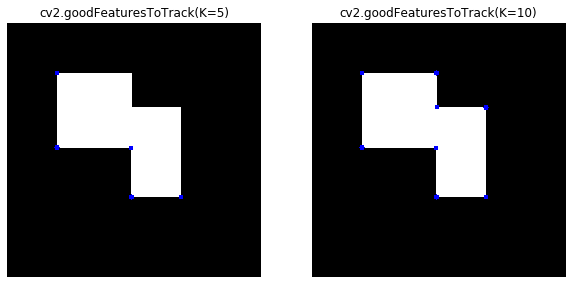

In [7]:
src = cv2.imread('./data/CornerTest.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

K=5
corners = cv2.goodFeaturesToTrack(gray,maxCorners=K,qualityLevel=0.05,minDistance=10)
print('corners.shape=',corners.shape)
print('corners=',corners)

K=10
corners2 = cv2.goodFeaturesToTrack(gray,maxCorners=K,qualityLevel=0.05,minDistance=10)
print('corners2.shape=',corners2.shape)
print('corners2=',corners2)

dst = src.copy()
dst2 = src.copy()

corners = corners.reshape(-1,2)
for x,y in corners:
    cv2.circle(dst,(x,y),5,(0,0,255),-1)
    
corners2 = corners2.reshape(-1,2)
for x,y in corners2:
    cv2.circle(dst2,(x,y),5,(0,0,255),-1)


plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('cv2.goodFeaturesToTrack(K=5)')
plt.axis('off')
plt.imshow(dst, cmap="gray")

imgae2=plt.subplot(1,2,2)
imgae2.set_title('cv2.goodFeaturesToTrack(K=10)')
plt.axis('off')
plt.imshow(dst2, cmap="gray")

plt.show()

### 체스보드 패턴 코너점 검출

<code>cv2.findChessboardCorners(image, patternSize[, corners[, flags]])</code>: 체스 판의 내부 모서리 위치를 찾는다.<br>

**parameter**
- image: input(chessboard)
- patternSize: 체스보드 안의 한 칸 column, row size
- corners: output
- flag: 0이거나 다양한 값의 조합이 될 수 있음
 - CALIB_CB_ADAPTIVE_THRESH
 - CALIB_CB_NORMALIZE_IMAGE
 - CALIB_CB_FILTER_QUADS
 - CALIB_CB_FAST_CHECK
 
<code>cv2.drawChessboardCorners(image, patternSize, corners, patternWasFound)</code>: 검출된 코너점 배열 corners를 8비트 컬러 image에 표시<br>

**parameter**
- image: Destination Image
- patternSize: Number of inner corners per a chessboard row and column
- corner: 검출한 코너점
- patternWasFound: Pattern을 검출하였나 안하였나 판단한는 Flag

<code>cv2.findCirclesGrid(image, patternSize[, centers[, flags]])</code>: 원 형태의 격자에서 원의 중심점을 검출한다.<br>

**현재 체스보드 패턴 코너점 검출은 광학 이미지의 보정을 통하여 Corner점을 찾아내는 방식이다.**  
광학이미지의 보정은 따로 공부하여 Post를 올릴 예정이다.  
따라서 추가적인 정확한 정보를 원하면 아래 링크를 참조하자.  
광학 이미지 보정: <a href="https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration">OpenCV Camera Clibration</a><br>
Method 자세한 내용: <a href="https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html">OpenCV 자세한 내용</a><br>

#### 체스보드 패턴 코너점 검출
<code>cv2.findChessboardCorners()</code>를 통하여 Chessboard에서의 코너점을 찾고  <code>cv2.cornerSubPix()</code>를 통하여 찾아진 코너에 대한 값을 보정하여 좀 더 정확한 위치를  
<code>cv2.drawChessboardCorners()</code>를 통하여 결과를 출력하였다.

True
corners.shape= (42, 1, 2)


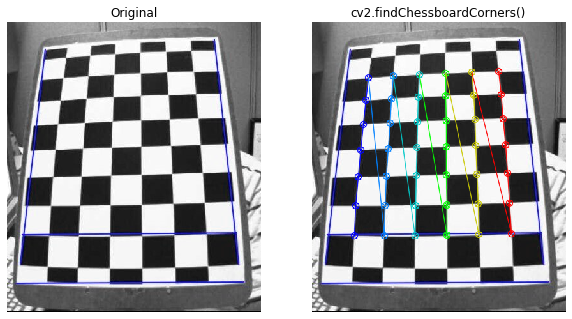

In [18]:
src = cv2.imread('./data/chessBoard.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
patternSize = (7,6)
found,corners = cv2.findChessboardCorners(src,patternSize)
print(found)
print('corners.shape=',corners.shape)

term_crit = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,10,0.01)
corners2 = cv2.cornerSubPix(gray,corners,(5,5),(-1,-1),term_crit)

dst = src.copy()
cv2.drawChessboardCorners(dst,patternSize,corners2,found)

plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(1,2,2)
imgae2.set_title('cv2.findChessboardCorners()')
plt.axis('off')
plt.imshow(dst)

plt.show()

#### 원 패턴 중심점 검출

centers.shape= (16, 1, 2)


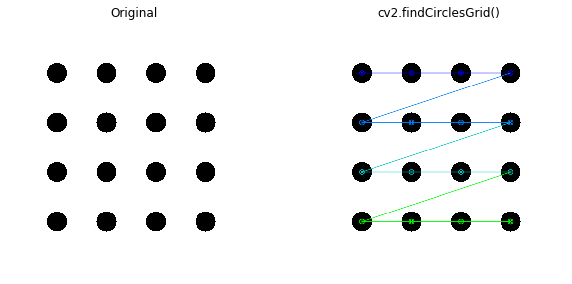

In [10]:
src = cv2.imread('./data/circleGrid.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
patternSize = (4,4)
found,centers = cv2.findCirclesGrid(src,patternSize)
print('centers.shape=',centers.shape)

term_crit = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,10,0.01)
centers2 = cv2.cornerSubPix(gray,centers,(5,5),(-1,-1),term_crit)

dst = src.copy()
cv2.drawChessboardCorners(dst,patternSize,centers2,found)

plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(1,2,2)
imgae2.set_title('cv2.findCirclesGrid()')
plt.axis('off')
plt.imshow(dst)

plt.show()

### 모멘트
**모멘트(moments)**란 화소의 가중평균으로 물체 인식을 위해 사용할 수 있는 디스크립터 이다.  

**과정**  
앞으로의 살펴볼 모멘트를 구하는 방법은 공통적으로 다음과 같은 과정을 거치게 된다.  
1. Image를 GrayScale로 변환
2. GrayScale을 Binary로서 표현
3. Moments 계산

위와 같은 과정을 거치게 되는 이유는 아래 Moments를 구하는 과정을 살펴보면 알 수 있다.  

**식**  
Moments를 살펴보기 위하여 다음과 같은 식을 가정하자.  
<p>$$M_{ij} = \sum_{x}\sum_{y}x^iy^jI(x,y)$$</p>
위와 같은 식에서 각각의 x, y에 대한 합을 구하기 위한 식은 아래와 같다.  

- 전체 합: <span>$M_{00} = \sum_{x}\sum_{y}I(x,y)$</span>

- x 합: <span>$M_{10}(\bar{x}) = \sum_{x}\sum_{y}xI(x,y)$</span>

- y 합: <span>$M_{01}(\bar{y}) = \sum_{x}\sum_{y}yI(x,y)$</span>

위와 같은 식으로서 중심 Moments 즉, **물체의 중심**을 알아보기 위한 식은 다음과 같다.  
<p>$$u_{ij} = \sum_{x}\sum_{y}(x-\bar{x})^i(y-\bar{y})^jI(x,y)$$</p>

위와 같은 식은 다양한 값이 나오므로 일정한 범위내에서 판단하기 위하여 **Normalization을 한 값은 다음과 같다.**  
<p>$$n_{ij} = \frac{u_{ij}}{u_{00}^{(i+j)/2+1}}$$</p>
<p>$$n_{00}, n_{10}, n_{01} = 0$$</p>

#### 영상 모멘트

m00=41001.0
m10=9454225.0
m01=8726225.0
m20=2397368875.0
m11=2119946125.0
m02=2023688875.0
m30=651249446875.0
m21=560532817875.0
m12=514587165875.0
m03=504399486875.0
mu20=217364232.4150629
mu11=107807529.58464432
mu02=166490203.00114632
mu30=-1790368560.1228027
mu21=584194816.4979553
mu12=2065142657.361374
mu03=2830588638.024536
nu20=0.1293001961152179
nu11=0.06412984584958643
nu02=0.09903752636820143
nu30=-0.00525964363794542
nu21=0.0017162145372477983
nu12=0.006066859461883883
nu03=0.008315543432356281


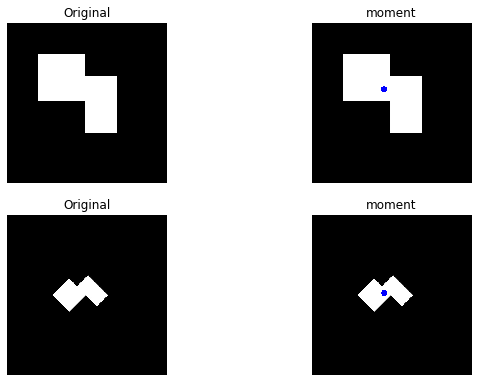

Corner_Test.jpg Moments:  230 212
Corner_Test_Rotation.jpg Moments:  231 249


In [33]:
src = cv2.imread('./data/CornerTest.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
ret,bimage = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)

M = cv2.moments(bimage,True)
for key,value in M.items():
    print('{}={}'.format(key,value))
    
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
dst = src.copy()
cv2.circle(dst,(cx,cy),10,(0,0,255),-1)

src2 = cv2.imread('./data/CornerTest_Rotation.jpg')
gray2 = cv2.cvtColor(src2,cv2.COLOR_BGR2GRAY)
ret2,bimage2 = cv2.threshold(gray2,128,255,cv2.THRESH_BINARY)

M2 = cv2.moments(bimage2,True)
cx2 = int(M2['m10']/M2['m00'])
cy2 = int(M2['m01']/M2['m00'])
dst2 = src2.copy()
cv2.circle(dst2,(cx2,cy2),10,(0,0,255),-1)


plt.figure(figsize=(10,10))

imgae1=plt.subplot(3,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(3,2,2)
imgae2.set_title('moment')
plt.axis('off')
plt.imshow(dst)

imgae3=plt.subplot(3,2,3)
imgae3.set_title('Original')
plt.axis('off')
plt.imshow(src2)

imgae4=plt.subplot(3,2,4)
imgae4.set_title('moment')
plt.axis('off')
plt.imshow(dst2)

plt.show()
print('Corner_Test.jpg Moments: ',cx,cy)
print('Corner_Test_Rotation.jpg Moments: ',cx2,cy2)

#### 경계선 모멘트
아래 Code는 각각의 Obejct를 검출하고 검출된 Obejct의 Moments를 구한다.

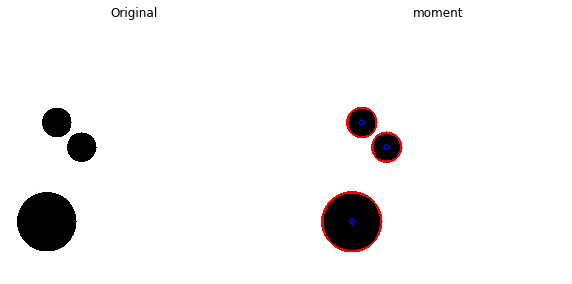

In [12]:
src = cv2.imread('./data/circle2.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
ret,bimage = cv2.threshold(gray,128,255,cv2.THRESH_BINARY_INV)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours,hierarchy = cv2.findContours(bimage,mode,method)

dst = src.copy()
cv2.drawContours(dst,contours,-1,(255,0,0),3)

for cnt in contours:
    M = cv2.moments(cnt,True)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(dst,(cx,cy),5,(0,0,255),2)
    
plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(1,2,2)
imgae2.set_title('moment')
plt.axis('off')
plt.imshow(dst)

plt.show()

#### Hu의 불변 모먼트
위와 같은 과정을 살펴보게 되면 Image에서 각각의 x, y 에대한 평균을 구하여 그 평균과의 차이를 통하여 물체의 중심인 **Moments**를 구할 수 있다.  

위의 과정으로 **Moments**를 구할 수 있으나 단점이 발생하게 된다.  
만약 같은 도형에 대하여 회전이나 Scaling이 일어나는 경우(중심의 좌표는 같다고 가정)에도 같은 Moments를 얻을 수 있을까?  
회전 같은 경우 계산하는 x,y의 좌표가 달라지므로 중심점인 Moments의 값이 달라지는 것을 위에서 결과로서 확인할 수 있었다.  
```code
Corner_Test.jpg Moments:  230 212
Corner_Test_Rotation.jpg Moments:  207 243
```
위와 같이 회전한 물체에 대해서 Momnets값이 달라지는 것을 확인 할 수 있다.  
**결과적으로 하나의 Feature로서 값을 얻어내서 ObjectDetection을 위해서는 Scaling이나 Rotation을 하여도 같은 Momentes로서 값을 뽑아낼 수 있어야 한다.**  
이러한 Moments를 얻기위하여 사용하는 방법이 Hu의 불변 모먼트 이다.  
<img src="https://www.learnopencv.com/wp-content/ql-cache/quicklatex.com-bed773267cd52c029f069695b1aa6c05_l3.png" height="190" width="849">


- <span>$h_0 \text{~} h_5$</span>: proved to be invariant to translation, scale, and rotation, and reflection
- <span>$h_6$</span>: sign changes for image reflection

**자세한 내용은 논문으로서 정의되어있다. 나중에 시간이 날때 살펴보도록하자.**<br>

<a href="https://ieeexplore.ieee.org/document/5485542?arnumber=5485542">Hu Moments 관련 논문</a><br>

아래 과정을 살펴보게 되면 Corner_Test.jpg Moments와 Corner_Test_Rotation.jpg Moments가 차이가 없는 것을 확인할 수 있다.

hu.shape= (7, 1)
hu= [[ 2.29512832e-01]
 [ 1.77264199e-02]
 [ 5.73565197e-04]
 [ 1.05422872e-04]
 [ 9.93149152e-09]
 [-7.94530682e-07]
 [-2.39456345e-08]]
A= [[ 1.41421356e-01  1.41421356e-01  1.87491761e+02]
 [-1.41421356e-01  1.41421356e-01  2.44545584e+02]]
hu2.shape= (7, 1)
hu2= [[ 2.29512832e-01]
 [ 1.77264199e-02]
 [ 5.73565197e-04]
 [ 1.05422872e-04]
 [ 9.93149152e-09]
 [-7.94530682e-07]
 [-2.39456345e-08]]
diffSum= 0.0
diffSum2= 0.0


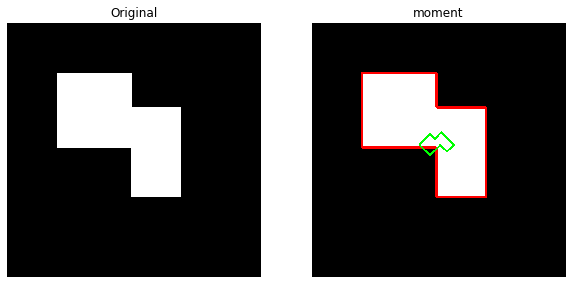

In [34]:
src = cv2.imread('./data/CornerTest.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
ret,bimage = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours,hierarchy = cv2.findContours(bimage,mode,method)

dst = src.copy()
cnt = contours[0]
cv2.drawContours(dst,[cnt],0,(255,0,0),3)

M = cv2.moments(cnt)
hu = cv2.HuMoments(M)
print('hu.shape=',hu.shape)
print('hu=',hu)

angle = 45.0
scale = 0.2
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
center = (cx,cy)
t = (20,30)
A = cv2.getRotationMatrix2D(center,angle,scale)
A[:,2] +=t
print('A=',A)
cnt2 = cv2.transform(cnt,A)
cv2.drawContours(dst,[cnt2],0,(0,255,0),3)

M2 = cv2.moments(cnt)
hu2 = cv2.HuMoments(M2)
print('hu2.shape=',hu2.shape)
print('hu2=',hu2)

diffSum = np.sum(cv2.absdiff(hu,hu2))
print('diffSum=',diffSum)

src2 = cv2.imread('./data/CornerTest_Rotation.jpg')
gray2 = cv2.cvtColor(src2,cv2.COLOR_BGR2GRAY)
ret2,bimage2 = cv2.threshold(gray2,128,255,cv2.THRESH_BINARY)
contours2,hierarchy2 = cv2.findContours(bimage2,mode,method)

dst2 = src2.copy()
cnt2 = contours[0]
cv2.drawContours(dst2,[cnt2],0,(255,0,0),3)

M3 = cv2.moments(cnt2)
hu3 = cv2.HuMoments(M3)

diffSum2 = np.sum(cv2.absdiff(hu,hu3))
print('diffSum2=',diffSum2)

plt.figure(figsize=(10,10))

imgae1=plt.subplot(1,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(1,2,2)
imgae2.set_title('moment')
plt.axis('off')
plt.imshow(dst)


plt.show()

### 모양 관련 특징 검출
연속된 좌표들로 주어지는 윤각선(경계선, <code>cv2.findContours()</code>)에 의한 물체의 모양과 관련된 특징을 검출할 수 있다.  

**길이,면적,사각형,삼각형, 원 검출 함수**  
<table class="table">
	<tr>
		<td>함수</td>
		<td>비고</td>
	</tr>
    <tr>
        <td><code>cv2.arcLength(curve,closed)</code></td>
		<td>길이</td>
	</tr>
    <tr>
        <td><code>cv2.contourArea(contour[,oriented])</code></td>
		<td>내부 면석</td>
	</tr>
    <tr>
        <td><code>cv2.boundingRect(points)</code></td>
		<td>최소사각형</td>
	</tr>
    <tr>
        <td><code>cv2.minAreaRect(points)</code></td>
		<td>최소면적 회전 박스</td>
	</tr>
    <tr>
        <td><code>cv2.boxPoints(box,[,points])</code></td>
		<td>박스의 꼭지점</td>
	</tr>
    <tr>
        <td><code>cv2.minEnclosingTriangle(points[,triangle])</code></td>
		<td>최소 삼각형</td>
	</tr>
    <tr>
        <td><code>cv2.minEnclosingCircle(points)</code></td>
		<td>최소원</td>
	</tr>
</table>
<br>
<br>

**직선 근사, 다각형 근사, 타원 근사, 다각형 내부 점 함수**  
<table class="table">
	<tr>
		<td>함수</td>
		<td>비고</td>
	</tr>
    <tr>
        <td><code>cv2.fitLine(points,distType,param,reps,aeps[,line])</code></td>
		<td>직선 근사</td>
	</tr>
    <tr>
        <td><code>cv2.fillEllipse(points)</code></td>
		<td>타원 근사</td>
	</tr>
    <tr>
        <td><code>cv2.approxPolyDP(curve,epsilon,closed[,approxCurve])</code></td>
		<td>다각형 근사</td>
	</tr>
    <tr>
        <td><code>cv2.pointPolygon(contour,pt,measureDist)</code></td>
		<td>다각형 내부 확인</td>
	</tr>
</table>
<br>
<br>

**블록 껍질(convex hull) 함수**  
<table class="table">
	<tr>
		<td>함수</td>
		<td>비고</td>
	</tr>
    <tr>
        <td><code>cv2.convexHull(points,[,hull[,clockwise[,returnPoints]]])</code></td>
		<td>블록 껍질</td>
	</tr>
    <tr>
        <td><code>cv2.isContourConvex(contour)</code></td>
		<td>블록 확인</td>
	</tr>
    <tr>
        <td><code>cv2.convexityDefects(contour,hull[,defects])</code></td>
		<td>블록 결함</td>
	</tr>
</table>
<br>
<br>

#### 길이, 면적, 사각형, 삼각형, 원 검출 함수
- Original: 원본 Image
- bimage: Binary Image
- dst2: 컨투어(Contour)검출
- dst3: <code>cv2.boundingRect()</code>로서 최소 사각형 Detect
- dst4: <code>cv2.minAreaRect()</code>로서 최소 면적 회전 박스 Detect
- dst5: <code>cv2.minEnclosingCircle()</code>로서 최소 원 Detect

**주의사항**  
현재 <code>cv2.findContours()</code>를 통하여 컨투어(contour)를 찾으면 7개를 찾는것을 확인할 수 있다.  
실제 찾은 Contour를 찾아서 표시하면 Image 하단부의 글자를 컨투어로 인식하여 제대로된 결과를 확인할 수 없다.  
따라서 **<code>cv2.arcLength()</code>에서 제일 길이가 긴 컨투어, 즉, 가장 큰 Object를 추출하여 Test용 이미지로서 사용**하였다.

len(contorus)= 7
maxLength= 2042.1677330732346
area= 48305.5
box= [[265 647]
 [ 76 496]
 [447  32]
 [636 183]]


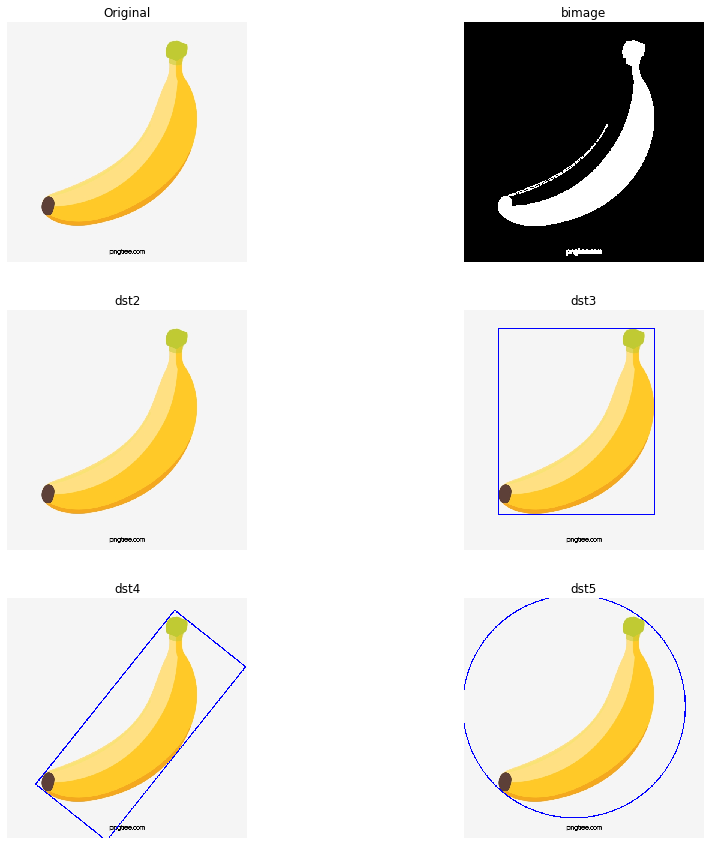

In [14]:
src = cv2.imread('./data/banana.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
ret,bimage = cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)
bimage = cv2.dilate(bimage,None)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours,hierarchy = cv2.findContours(bimage,mode,method)
print('len(contorus)=',len(contours))

maxLength=0
k=0
for i,cnt in enumerate(contours):
    perimeter = cv2.arcLength(cnt,closed=True)
    if perimeter > maxLength:
        maxLength = perimeter
        k=i
print('maxLength=',maxLength)
cnt = contours[k]
dst2 = src.copy()

area = cv2.contourArea(cnt)
print('area=',area)
x,y,width,height = cv2.boundingRect(cnt)
dst3 = dst2.copy()
cv2.rectangle(dst3,(x,y),(x+width,y+height),(0,0,255),2)

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int32(box)
print('box=',box)
dst4 = dst2.copy()
cv2.drawContours(dst4,[box],0,(0,0,255),2)

(x,y),radius = cv2.minEnclosingCircle(cnt)
dst5 = dst2.copy()
cv2.circle(dst5,(int(x),int(y)),int(radius),(0,0,255),2)

plt.figure(figsize=(15,15))

imgae1=plt.subplot(3,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(3,2,2)
imgae2.set_title('bimage')
plt.axis('off')
plt.imshow(bimage, cmap="gray")

imgae2=plt.subplot(3,2,3)
imgae2.set_title('dst2')
plt.axis('off')
plt.imshow(dst2)

imgae3=plt.subplot(3,2,4)
imgae3.set_title('dst3')
plt.axis('off')
plt.imshow(dst3)

imgae4=plt.subplot(3,2,5)
imgae4.set_title('dst4')
plt.axis('off')
plt.imshow(dst4)

imgae5=plt.subplot(3,2,6)
imgae5.set_title('dst5')
plt.axis('off')
plt.imshow(dst5)

plt.show()

#### 직선, 다각형, 타원 근사 및 내부 점 확인
- Original: 원본 Image
- bimage: Binary Image
- dst2: <code>cv2.fitLine()</code>로서 직선 근사 Detect
- dst3: <code>cv2.fitEllipse()</code>로서 타원 근사 Detect
- dst4: <code>cv2.approxPolyDP()</code>로서 다각형 근사 Detect
- dst5: <code>cv2.pointPolygonTest()</code>로서 다각형 내부 확인


maxLength= 2042.1677330732346


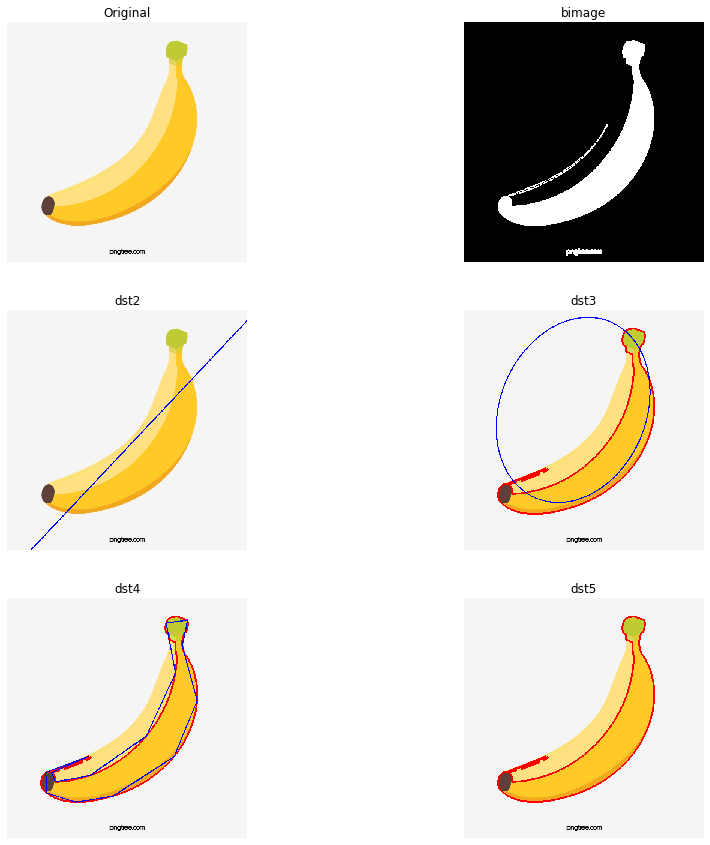

In [15]:
src = cv2.imread('./data/banana.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
ret,bimage = cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)
bimage = cv2.dilate(bimage,None)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours,hierarchy = cv2.findContours(bimage,mode,method)

maxLength=0
k=0
for i,cnt in enumerate(contours):
    perimeter = cv2.arcLength(cnt,closed=True)
    if perimeter > maxLength:
        maxLength = perimeter
        k=i
print('maxLength=',maxLength)
cnt = contours[k]

dst = src.copy()
cv2.drawContours(dst,[cnt],0,(255,0,0),3)

dst2 = src.copy()
rows,cols = dst2.shape[:2]
[vx,vy,x,y] = cv2.fitLine(cnt,cv2.DIST_L2,0,0.01,0.01)
y1 = int((-x*vy/vx)+y)
y2 = int((((cols-x)*vy)/vx)+y)
cv2.line(dst2,(0,y1),(cols-1,y2),(0,0,255),2)

ellipse = cv2.fitEllipse(cnt)
dst3 = dst.copy()
cv2.ellipse(dst3,ellipse,(0,0,255),2)

poly = cv2.approxPolyDP(cnt,epsilon=20,closed=True)
dst4 = dst.copy()
cv2.drawContours(dst4,[poly],0,(0,0,255),2)

dst5 = dst.copy()
for y in range(rows):
    for x in range(cols):
        if cv2.pointPolygonTest(cnt,(x,y),False)>0:
            dst[y,x] = (0,255,0)
            
plt.figure(figsize=(15,15))

imgae1=plt.subplot(3,2,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(3,2,2)
imgae2.set_title('bimage')
plt.axis('off')
plt.imshow(bimage, cmap="gray")

imgae2=plt.subplot(3,2,3)
imgae2.set_title('dst2')
plt.axis('off')
plt.imshow(dst2)

imgae3=plt.subplot(3,2,4)
imgae3.set_title('dst3')
plt.axis('off')
plt.imshow(dst3)

imgae4=plt.subplot(3,2,5)
imgae4.set_title('dst4')
plt.axis('off')
plt.imshow(dst4)

imgae5=plt.subplot(3,2,6)
imgae5.set_title('dst5')
plt.axis('off')
plt.imshow(dst5)

plt.show()

#### 블록 껍질
- Original: 원본 Image에 medianBlur LPF를 통하여 Noise 제거 -> hsv로 변환 -> v(명도) Normalization
- dst: src Contour검출
- dst2: <code>cv2.convexHull()</code>로서 블록 껍질 Detect
- dst3: <code>cv2.convexHull(returnPoints=False)</code>로서 블록 껍질 Detect
- dst4: <code>cv2.convexityDefects(cnt,hull)</code>로서 블록 결함 Detect<br>Convexity와 Object 까지의 거리 T1(10)이상 Detect
- dst5: <code>cv2.convexityDefects(cnt,hull)</code>로서 블록 결함 Detect<br>Convexity와 Object 까지의 거리 T2(50)이상 Detect

<br>

**참고사항: cv2.convexityDefects()**  
블록 결함이란 연결한 Convexity와 Object까지의 가장 먼 점을 찾는 것이다.  
아래 그림을 참조하면 이해가 더 편하다.  
<img src="https://mblogthumb-phinf.pstatic.net/20151031_44/samsjang_1446220358723kI0vg_JPEG/2015-10-31_005141.jpg?type=w2" largesrc="javascript:location.href='https://mblogthumb-phinf.pstatic.net/20151031_44/samsjang_1446220358723kI0vg_JPEG/2015-10-31_005141.jpg?type=w2'" id="img_4" data-top="2611"><br>
그림 참조: <a href="https://m.blog.naver.com/PostView.nhn?blogId=samsjang&logNo=220524551089&proxyReferer=https%3A%2F%2Fwww.google.com%2F">옥수별 Blog</a><br>

maxLength= 900.70057117939
defects.shape= [[[  198   239   226 11411]]

 [[  240   242   241   114]]

 [[  242   275   263 13582]]

 [[    0    25     7 11551]]

 [[   26    65    43 10203]]

 [[   65    67    66   162]]

 [[   68    70    69   226]]

 [[   70    78    75   290]]

 [[   78    88    85   261]]

 [[   88   130   123  2135]]

 [[  131   197   144  5143]]]


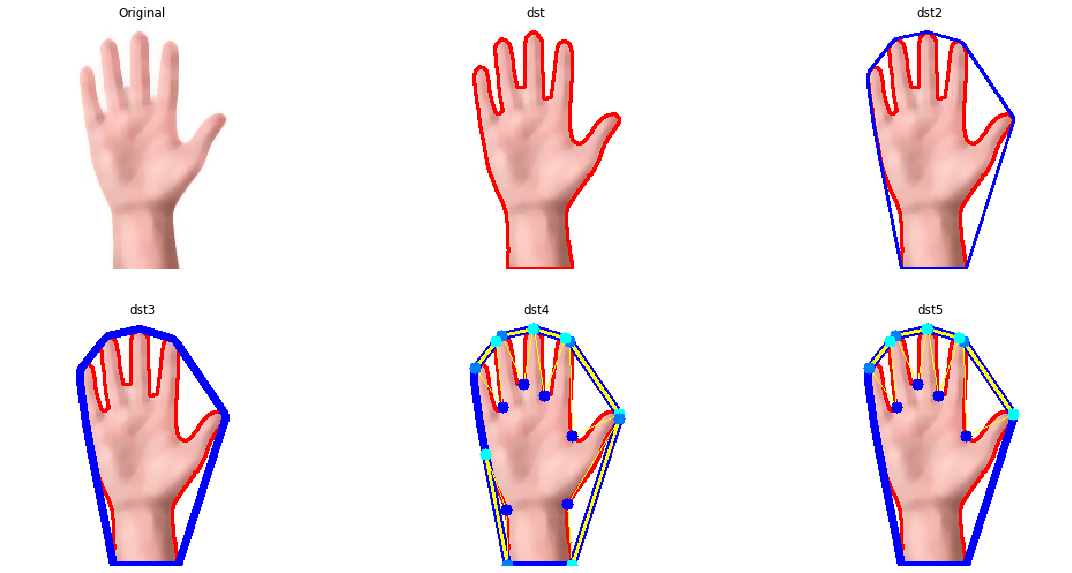

In [36]:
src = cv2.imread('./data/hand.jpg')
src = cv2.medianBlur(src,ksize=11)
hsv = cv2.cvtColor(src,cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)
v2 = cv2.equalizeHist(v)
hsv = cv2.merge([h,s,v2])
src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)

lowerb = (0,40,0)
upperb = (20,180,255)
bimage = cv2.inRange(hsv,lowerb,upperb)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours,hierachy = cv2.findContours(bimage,mode,method)

dst = src.copy()
maxLength=0
k=0
for i,cnt in enumerate(contours):
    perimeter = cv2.arcLength(cnt,closed=True)
    if perimeter > maxLength:
        maxLength = perimeter
        k=i
print('maxLength=',maxLength)
cnt = contours[k]
cv2.drawContours(dst,[cnt],0,(255,0,0),2)

dst2 = dst.copy()
rows,cols = dst2.shape[:2]
hull = cv2.convexHull(cnt)
cv2.drawContours(dst2,[hull],0,(0,0,255),2)


dst3 = dst.copy()
hull = cv2.convexHull(cnt,returnPoints=False)
hull_points = cnt[hull[:,0]]
cv2.drawContours(dst3,[hull_points],0,(0,0,255),6)

T= 10
T2 = 50

dst4 = dst3.copy()
dst5 = dst3.copy()

defects = cv2.convexityDefects(cnt,hull)
print('defects.shape=',defects)

for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    dist = d/128
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    
    if dist> T2:
        cv2.line(dst5,start,end,[255,255,0],2)
        cv2.line(dst5,start,far,[255,255,0],1)
        cv2.line(dst5,end,far,[255,255,0],1)
        
        cv2.circle(dst5,start,5,[0,255,255],-1)
        cv2.circle(dst5,end,5,[0,128,255],-1)
        cv2.circle(dst5,far,5,[0,0,255],-1)
    
    if dist>T:
        cv2.line(dst4,start,end,[255,255,0],2)
        cv2.line(dst4,start,far,[255,255,0],1)
        cv2.line(dst4,end,far,[255,255,0],1)
        
        cv2.circle(dst4,start,5,[0,255,255],-1)
        cv2.circle(dst4,end,5,[0,128,255],-1)
        cv2.circle(dst4,far,5,[0,0,255],-1)

plt.figure(figsize=(20,10))

imgae1=plt.subplot(2,3,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src)

imgae2=plt.subplot(2,3,2)
imgae2.set_title('dst')
plt.axis('off')
plt.imshow(dst)

imgae3=plt.subplot(2,3,3)
imgae3.set_title('dst2')
plt.axis('off')
plt.imshow(dst2)

imgae4=plt.subplot(2,3,4)
imgae4.set_title('dst3')
plt.axis('off')
plt.imshow(dst3)

imgae5=plt.subplot(2,3,5)
imgae5.set_title('dst4')
plt.axis('off')
plt.imshow(dst4)

imgae6=plt.subplot(2,3,6)
imgae6.set_title('dst5')
plt.axis('off')
plt.imshow(dst5)

plt.show()

### 모양 매칭
이전 Post <a href="https://wjddyd66.github.io/opencv/2019/10/29/OpenCV(5).html">OpenCV-영상 공간 필터링</a>에서 **템플렛 매칭같은 경우 Rotation이나 Scaling은 Detect하지 못하는 한계점이 있다고 Post했었다.**  

하지만 위에서 **Image의 Feature 중 Moments를 사용하는 경우 Hu Moments를 구하면 Rotation, Scaling등에 영향을 받지 않고 일정한 값을 출력 한다는 것을 알았다.**  
모양 매칭은 이러한 Hu Moments를 통하여 Maching하는 Object를 찾는 방법이다.  

<code>cv2.matchShapes(contour1,contour2,method,parameter)</code>: 각각의 Object의 Contour를 Hu Moments로 비교하여 Mathcing하는 Object검출, Object가 닮은 정도가 높을수록 0에 가까운 값으로 Return한다.<br>

**parameter**
- contour1: Input Image1 Contour
- contour2: Input Image2 Contour
- method: 매칭 방법
 - CV_CONTOURS_MATCH_l1: <span>$I_1(A,B) = \sum_{i=0}^{6} |\frac{1}{m_i^A} - \frac{1}{m_i^B}|$</span>
 - CV_CONTOURS_MATCH_l2: <span>$I_1(A,B) = \sum_{i=0}^{6} |m_i^A - m_i^B|$</span>
 - CV_CONTOURS_MATCH_l3: <span>$I_1(A,B) = \sum_{i=0}^{6} max(\frac{|m_i^A - m_i^B|}{|m_i^A|})$</span>
 - <span>$m_i^A = sign(hu(i)^A) x log(hu(i)^A)$</span>
 - <span>$m_i^A = sign(hu(i)^A) x log(hu(i)^A)$</span>
 

#### 모양매칭
아래 Code를 살펴보게 되면 각각의 Contour를 구한 뒤 <code>cv2.matchShapes()</code>의 값이 가장 적은 값, 즉 Object가 가장 닮은 것 끼리 같은 색으로 <code>cv2.drawContours()</code>를 수행하여 Obejct Maching결과를 표시하는 것을 알 수 있다.

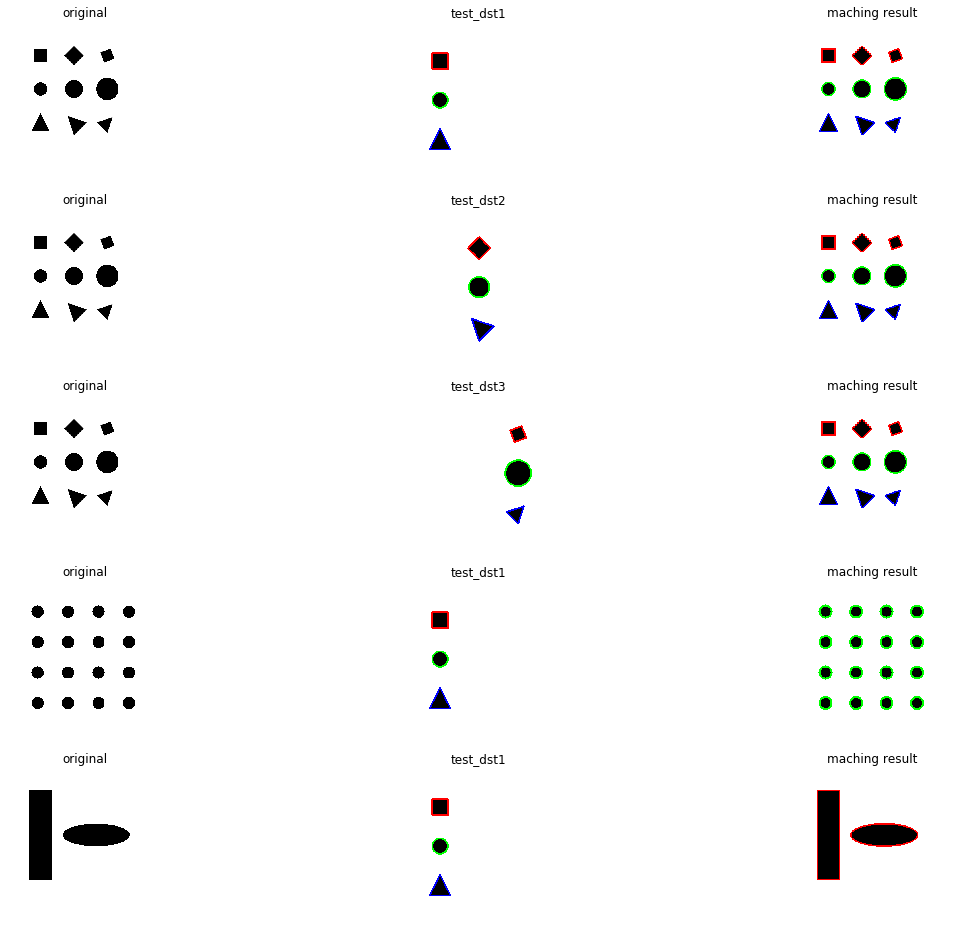

In [141]:
ref_src = cv2.imread('./data/refShapes.jpg')
ref_gray = cv2.cvtColor(ref_src,cv2.COLOR_BGR2GRAY)
ret,ref_bin = cv2.threshold(ref_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

ref_src2 = cv2.imread('./data/circleGrid.jpg')
ref_gray2 = cv2.cvtColor(ref_src2,cv2.COLOR_BGR2GRAY)
ret2,ref_bin2 = cv2.threshold(ref_gray2,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

ref_src3 = np.zeros((700,700,3),dtype=np.uint8)+255
cv2.rectangle(ref_src3,(100,100),(200,500),(0,0,0),-1)

ptCenter = 400, 300
size = 150,50
cv2.ellipse(ref_src3,ptCenter,size,0,0,360,(0,0,0),-1)

ref_gray3 = cv2.cvtColor(ref_src3,cv2.COLOR_BGR2GRAY)
ret3,ref_bin3 = cv2.threshold(ref_gray3,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

test_src1 = cv2.imread('./data/refShapes1.jpg')
test_src2 = cv2.imread('./data/refShapes2.jpg')
test_src3 = cv2.imread('./data/refShapes3.jpg')
test_gray1 = cv2.cvtColor(test_src1,cv2.COLOR_BGR2GRAY)
test_gray2 = cv2.cvtColor(test_src2,cv2.COLOR_BGR2GRAY)
test_gray3 = cv2.cvtColor(test_src3,cv2.COLOR_BGR2GRAY)
ret,test_bin1 = cv2.threshold(test_gray1,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret,test_bin2 = cv2.threshold(test_gray2,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret,test_bin3 = cv2.threshold(test_gray3,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE

ref_contours,_ = cv2.findContours(ref_bin,mode,method)
ref_contours2,_ = cv2.findContours(ref_bin2,mode,method)
ref_contours3,_ = cv2.findContours(ref_bin3,mode,method)

test_contours1,_ = cv2.findContours(test_bin1,mode,method)
test_contours2,_ = cv2.findContours(test_bin2,mode,method)
test_contours3,_ = cv2.findContours(test_bin3,mode,method)

test_dst1 = test_src1.copy()
test_dst2 = test_src2.copy()
test_dst3 = test_src3.copy()

colors = ((0,0,255),(0,255,0),(255,0,0),(255,255,0))

def matching_find(test_contours,test_dst):
    for i,cnt in enumerate(test_contours):
        cv2.drawContours(test_dst,[cnt],0,colors[i],5)

matching_find(test_contours1,test_dst1)
matching_find(test_contours2,test_dst2)
matching_find(test_contours3,test_dst3)

def matching_find2(ref_contours,ref_dst,test_contours):
    for i,cnt1 in enumerate(ref_contours):
        matches = []
        for cnt2 in test_contours:
            ret = cv2.matchShapes(cnt1,cnt2,method,0)
            matches.append(ret)
        k = np.argmin(matches)
        cv2.drawContours(ref_dst,[cnt1],0,colors[k],5)

ref_dst1 = ref_src.copy()
ref_dst2 = ref_src.copy()
ref_dst3 = ref_src.copy()
ref_dst4 = ref_src2.copy()
ref_dst5 = ref_src3.copy()

matching_find2(ref_contours,ref_dst1,test_contours1)
matching_find2(ref_contours,ref_dst2,test_contours2)
matching_find2(ref_contours,ref_dst3,test_contours3)
matching_find2(ref_contours2,ref_dst4,test_contours1)
matching_find2(ref_contours3,ref_dst5,test_contours1)

plt.figure(figsize=(20,20))
imgae1=plt.subplot(6,3,1)
imgae1.set_title('original')
plt.axis('off')
plt.imshow(ref_src)

imgae2=plt.subplot(6,3,2)
imgae2.set_title('test_dst1')
plt.axis('off')
plt.imshow(test_dst1)

imgae3=plt.subplot(6,3,3)
imgae3.set_title('maching result')
plt.axis('off')
plt.imshow(ref_dst1)

imgae4=plt.subplot(6,3,4)
imgae4.set_title('original')
plt.axis('off')
plt.imshow(ref_src)

imgae5=plt.subplot(6,3,5)
imgae5.set_title('test_dst2')
plt.axis('off')
plt.imshow(test_dst2)

imgae6=plt.subplot(6,3,6)
imgae6.set_title('maching result')
plt.axis('off')
plt.imshow(ref_dst2)


imgae7=plt.subplot(6,3,7)
imgae7.set_title('original')
plt.axis('off')
plt.imshow(ref_src)

imgae8=plt.subplot(6,3,8)
imgae8.set_title('test_dst3')
plt.axis('off')
plt.imshow(test_dst3)

imgae9=plt.subplot(6,3,9)
imgae9.set_title('maching result')
plt.axis('off')
plt.imshow(ref_dst3)


imgae10=plt.subplot(6,3,10)
imgae10.set_title('original')
plt.axis('off')
plt.imshow(ref_src2)

imgae11=plt.subplot(6,3,11)
imgae11.set_title('test_dst1')
plt.axis('off')
plt.imshow(test_dst1)

imgae12=plt.subplot(6,3,12)
imgae12.set_title('maching result')
plt.axis('off')
plt.imshow(ref_dst4)

imgae13=plt.subplot(6,3,13)
imgae13.set_title('original')
plt.axis('off')
plt.imshow(ref_src3)

imgae14=plt.subplot(6,3,14)
imgae14.set_title('test_dst1')
plt.axis('off')
plt.imshow(test_dst1)

imgae15=plt.subplot(6,3,15)
imgae15.set_title('maching result')
plt.axis('off')
plt.imshow(ref_dst5)

plt.show()

**결과를 살펴보게 되면 Rotation이나 Scaling 경우에도 잘 찾아내는 것을 알 수 있다. 개인적으로는 타원이랑은 원이랑 비슷하다고 생각되지만, Open CV에서는 사각형이랑 더 비슷하다고 나왔다.**  
이러한 특이한 사항같은 경우는 Feature를 더 추가하여 판별하도록 정의하여야 한다.

### 적분
적분 영상이란 영상의 부분 영역(subregion) 내부에 있는 화소의 합을 누적하는 과정이다.  
이러한 적분 영상은 영상안의 여러 관심 영역을 대상으로 이전에 다룬 히스토그램 같은 여러가지를 계산한다고 가정하자.  
이런 모든 계산에 드는 비용은 매우 급격하게 늘어날 수 있다.  
이러한 계산중 특정 계산 사각 영역의 합계, 평균, 표준편차 등을 빠르게 계산하기 위하여 사용한다.  
<img src="https://mblogthumb-phinf.pstatic.net/20151115_257/windowsub0406_1447579045550APImK_PNG/1432.png?type=w800"><br>
사진 출처:<a href="https://m.blog.naver.com/PostView.nhn?blogId=windowsub0406&logNo=220539823903&proxyReferer=https%3A%2F%2Fwww.google.com%2F">끄적끄적 블로그</a><br>

위와같은 적분 결과를 얻었다고 하자  
점 A는 영상의 왼쪽 위 부터 A점까지의 화소의 합이라 할 수 있다.  
그렇다면 A,B,C,D를 알고 있는 상황에서 영역 M의 면적을 구하기 위해서는 D - B - C + A라는 단순한 계산으로서 해결할 수 있다.  

**M의 면적의 상관없이 빠르게 계산할 수 있다는 장점이 생기게 된다.**  
**하지만 중요한 점은, 적분 영상 계산은 모든 영상 화소를 일단 한번 순회해야 하기 때문에 초기 비용이 많이 드는 작업이다.**  

적분을 지원하는 OpenCV의 코드는 다음과 같다.  
<code>cv2.intral(src,[,sum[,sdepth]]) -> sum </code><br>
<code>cv2.intral(src,[,sum[,sqsum[,sdepth]]]) -> sum,sqsum </code><br>
<code>cv2.intral(src,[,sum[,sqsum[,tilted[,sdepth]]]]) -> sum,sqsum,tilted </code><br>

<p>$$sum(X,Y) = \sum_{y \leq Y}\sum_{x \leq X}src(x,y)$$</p>
<p>$$sqsum(X,Y) = \sum_{y \leq Y}\sum_{x \leq X}src(x,y)^2$$</p>
<p>$$tilted(X,Y) = \sum_{y \nless Y}\sum_{abs(x-X) \leq y}src(x,y)$$</p>

#### 적분영상1

In [120]:
A = np.arange(1,17).reshape(4,4).astype(np.uint8)
print('A=',A)

sumA,sqsumA,tiltedA = cv2.integral3(A)
print('sumA=',sumA)
print('sqsumA=',sqsumA)
print('tiltedA=',tiltedA)

A= [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
sumA= [[  0   0   0   0   0]
 [  0   1   3   6  10]
 [  0   6  14  24  36]
 [  0  15  33  54  78]
 [  0  28  60  96 136]]
sqsumA= [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 5.000e+00 1.400e+01 3.000e+01]
 [0.000e+00 2.600e+01 6.600e+01 1.240e+02 2.040e+02]
 [0.000e+00 1.070e+02 2.470e+02 4.260e+02 6.500e+02]
 [0.000e+00 2.760e+02 6.120e+02 1.016e+03 1.496e+03]]
tiltedA= [[ 0  0  0  0  0]
 [ 0  1  2  3  4]
 [ 1  8 12 16 15]
 [ 8 26 38 42 36]
 [26 60 80 84 70]]


#### 적분영상2

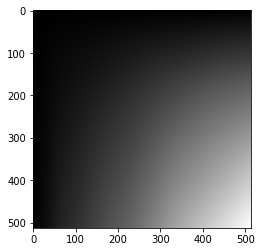

In [129]:
gray = cv2.imread('./data/lena.jpg',0)
gray_sum = cv2.integral(gray)
dst = cv2.normalize(gray_sum,None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
dst = cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)

plt.imshow(dst, cmap='gray')